## Import Libraries

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools


In [4]:
df = pd.read_csv("Dataset Nabarangpur Maize Avg Price.csv")

In [5]:
import pandas as pd

# Sample Data
data = {
    "Date": ["31-Jan-10", "28-Feb-10", "31-Mar-10", "30-Apr-10", "31-May-10"],
    "Avg Price": [871.458333, 873.976191, 858.475000, 863.031250, 851.460000]
}

df = pd.DataFrame(data)

# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%y")

# Extract only Month and Year
df["Month_Year"] = df["Date"].dt.strftime("%b-%Y")  # Format as "Jan-2010"

# Drop the original "Date" column if not needed
df = df.drop(columns=["Date"])

# Display the updated DataFrame
print(df)


    Avg Price Month_Year
0  871.458333   Jan-2010
1  873.976191   Feb-2010
2  858.475000   Mar-2010
3  863.031250   Apr-2010
4  851.460000   May-2010


In [6]:
print(df.head())

    Avg Price Month_Year
0  871.458333   Jan-2010
1  873.976191   Feb-2010
2  858.475000   Mar-2010
3  863.031250   Apr-2010
4  851.460000   May-2010


In [7]:
print(df.tail())

    Avg Price Month_Year
0  871.458333   Jan-2010
1  873.976191   Feb-2010
2  858.475000   Mar-2010
3  863.031250   Apr-2010
4  851.460000   May-2010


In [8]:
print(df.describe())  # Get basic statistical summary


        Avg Price
count    5.000000
mean   863.680155
std      9.264925
min    851.460000
25%    858.475000
50%    863.031250
75%    871.458333
max    873.976191


C:\Users\akash\AppData\Local\Temp\ipykernel_9636\3782360780.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("Dataset Nabarangpur Maize Avg Price.csv", parse_dates=["Date"], index_col="Date")


Columns in DataFrame: ['Avg Price']


<Figure size 1000x600 with 0 Axes>

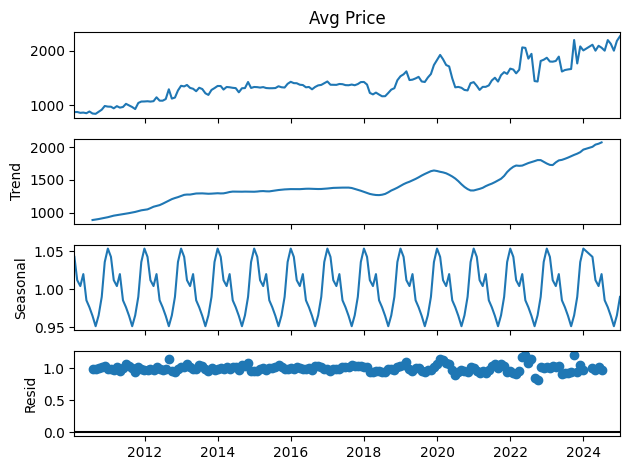

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv("Dataset Nabarangpur Maize Avg Price.csv", parse_dates=["Date"], index_col="Date")

# Strip spaces and check column names
df.columns = df.columns.str.strip()
print("Columns in DataFrame:", df.columns.tolist())  # Debugging step

# Find the correct column name dynamically
column_name = [col for col in df.columns if "avg price" in col.lower()]
if not column_name:
    raise KeyError("Error: 'Avg Price' column not found in the dataset.")
else:
    column_name = column_name[0]

# Convert to numeric and handle missing values
df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
df.dropna(inplace=True)

# Check for zero or negative values
if (df[column_name] <= 0).any():
    print("Warning: Multiplicative model requires all values to be positive.")
    print("Switching to an additive model.")
    model_type = "additive"
else:
    model_type = "multiplicative"

# Perform time series decomposition
decomposition = seasonal_decompose(df[column_name], model=model_type, period=12)

# Plot the decomposition
plt.figure(figsize=(10, 6))
decomposition.plot()
plt.show()



In [10]:
result = adfuller(df["Avg Price"])  # Replace 'value_column' with your actual column name
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is NOT stationary. Consider differencing.")


ADF Statistic: -0.17366555634862188
p-value: 0.9415886789531794
Critical Values: {'1%': np.float64(-3.469648263987657), '5%': np.float64(-2.878798906308495), '10%': np.float64(-2.5759713094779593)}
The data is NOT stationary. Consider differencing.


Columns in DataFrame: ['Avg Price']
ADF Statistic: -0.1737
p-value: 0.9416
Critical Values: {'1%': np.float64(-3.469648263987657), '5%': np.float64(-2.878798906308495), '10%': np.float64(-2.5759713094779593)}
The series is non-stationary (p >= 0.05)

After 1 differencing:
ADF Statistic: -6.9924
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.469648263987657), '5%': np.float64(-2.878798906308495), '10%': np.float64(-2.5759713094779593)}
The series is stationary (p < 0.05)


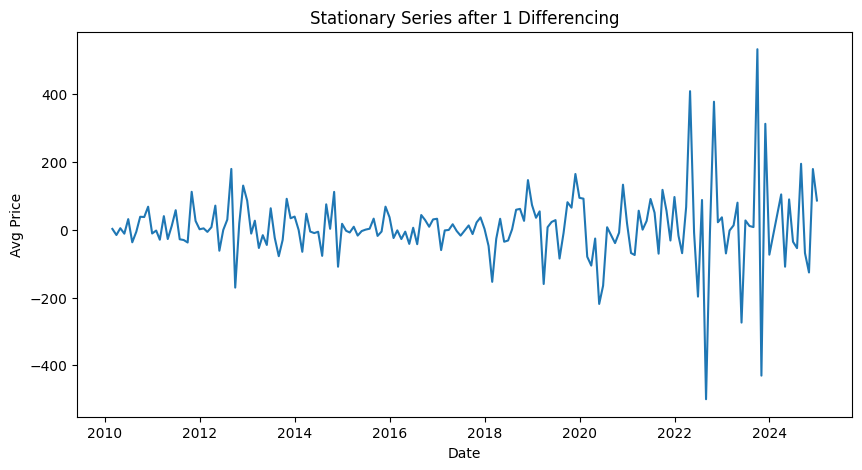

In [11]:
# Fix duplicate indices (drop duplicates)
df = df[~df.index.duplicated(keep="first")]

# Ensure data is sorted by date
df = df.sort_index()

# Clean column names
df.columns = df.columns.str.strip()

# Check available columns
print("Columns in DataFrame:", df.columns.tolist())

# Find correct column name dynamically
column_name = [col for col in df.columns if "avg price" in col.lower()]
if not column_name:
    raise ValueError("Error: 'Avg Price' column not found in dataset. Check column names.")
else:
    column_name = column_name[0]

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("The series is stationary (p < 0.05)")
        return True
    else:
        print("The series is non-stationary (p >= 0.05)")
        return False

# Function to apply differencing until stationarity
def make_stationary(df, column):
    series = df[column]
    difference_order = 0

    while not adf_test(series) and difference_order < 3:  # Limit to 3 differencing steps
        difference_order += 1
        series = series.diff().dropna()
        print(f"\nAfter {difference_order} differencing:")

    if difference_order == 3:
        print("Warning: Series is still not stationary after 3 differencing steps.")

    return series, difference_order

# Apply differencing to the correct column
stationary_series, diff_order = make_stationary(df, column_name)

# Plot the stationary series
plt.figure(figsize=(10, 5))
sns.lineplot(data=stationary_series)
plt.title(f"Stationary Series after {diff_order} Differencing")
plt.xlabel("Date")
plt.ylabel("Avg Price")
plt.show()


In [12]:
# Ensure first differencing is applied correctly
if "Diff" not in df.columns:
    df["Diff"] = df["Avg Price"].diff().dropna()  # Apply first differencing


In [13]:
df['First_Diff'] = df['Avg Price'].diff()

result_diff1 = adfuller(df['First_Diff'].dropna())
print(f"ADF Statistic after first differencing: {result_diff1[0]}")
print(f"p-value: {result_diff1[1]}")

if result_diff1[1] < 0.05:
    print("First differencing is sufficient.")
else:
    print("Still not stationary. Second differencing might be needed.")

ADF Statistic after first differencing: -6.992371282252077
p-value: 7.686180630729893e-10
First differencing is sufficient.


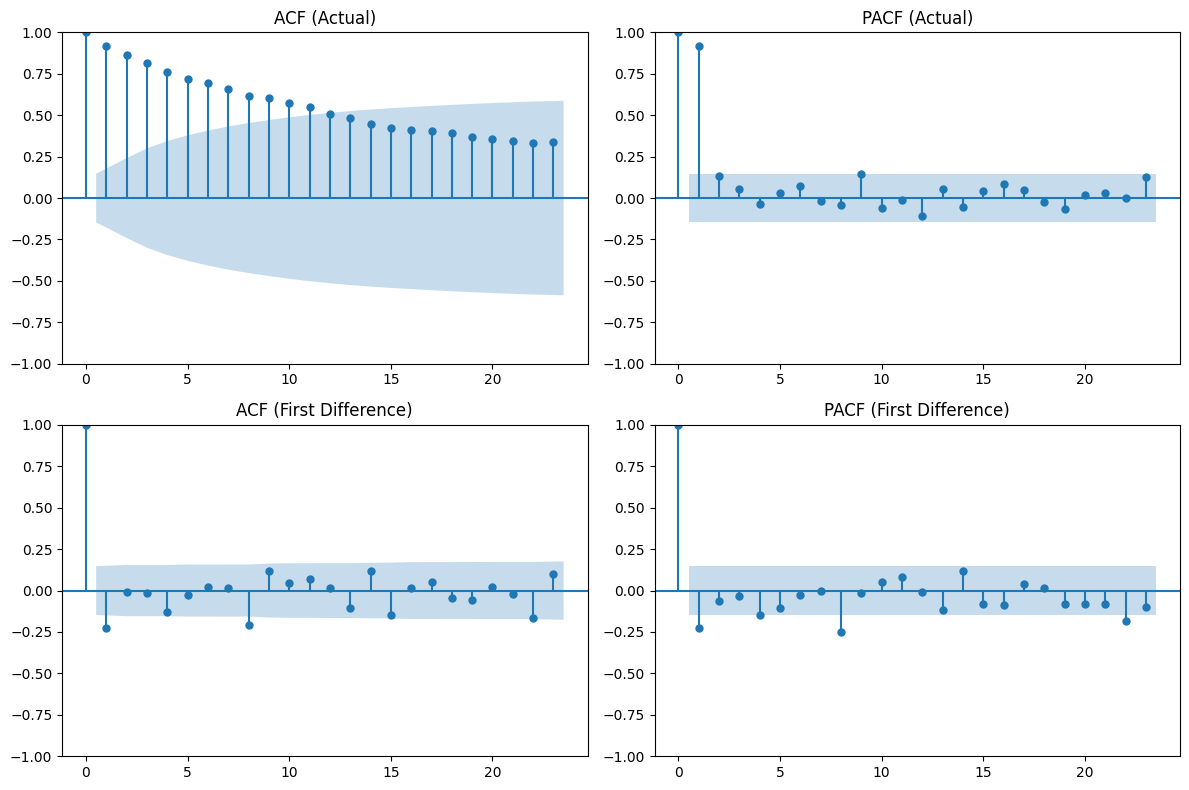

In [14]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF and PACF for Actual Data
plot_acf(df["Avg Price"].dropna(), ax=axes[0, 0])
axes[0, 0].set_title("ACF (Actual)")

plot_pacf(df["Avg Price"].dropna(), ax=axes[0, 1])
axes[0, 1].set_title("PACF (Actual)")

# Plot ACF and PACF for First Differenced Data (if needed)
if "Diff" in df.columns:
    plot_acf(df["Diff"].dropna(), ax=axes[1, 0])
    axes[1, 0].set_title("ACF (First Difference)")

    plot_pacf(df["Diff"].dropna(), ax=axes[1, 1])
    axes[1, 1].set_title("PACF (First Difference)")

plt.tight_layout()
plt.show()


In [15]:
import warnings
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

best_aic = float('inf')
best_bic = float('inf')
best_order = None

# Define range for p and q, and fix d = 1
p_range = range(1, 6)
q_range = range(1, 6)
d = 1  # Fixing d = 1 based on ADF test

# Iterate over all possible (p, 1, q) combinations
for p, q in itertools.product(p_range, q_range):
    try:
        # Fit ARIMA model
        model = ARIMA(df['Avg Price'], order=(p, d, q))
        model_fit = model.fit()

        # Compare AIC and BIC to find the best model
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_bic = model_fit.bic
            best_order = (p, d, q)

    except Exception as e:
        print(f"ARIMA({p}, {d}, {q}) failed: {e}")
        continue

# Display the best model
if best_order:
    print(f"\nBest ARIMA Model: ARIMA({best_order[0]}, {best_order[1]}, {best_order[2]})")
    print(f"AIC: {best_aic:.2f}, BIC: {best_bic:.2f}")
else:
    print("No valid ARIMA model was found.")


c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro


Best ARIMA Model: ARIMA(3, 1, 3)
AIC: 2143.32, BIC: 2165.55


c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
# p = 3, d = 1, q = 3
# Now we build and train the model
model = ARIMA(df['Avg Price'], order = (3, 1, 3))
arima_result = model.fit()
print(arima_result.summary())

c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:              Avg Price   No. Observations:                  178
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1064.660
Date:                Sun, 02 Mar 2025   AIC                           2143.320
Time:                        17:26:09   BIC                           2165.554
Sample:                             0   HQIC                          2152.337
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2458      0.128      1.927      0.054      -0.004       0.496
ar.L2         -0.5758      0.106     -5.419      0.000      -0.784      -0.368
ar.L3          0.5679      0.142      4.010      0.0

c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
import warnings
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

best_aic = float('inf')
best_bic = float('inf')
best_order = None

# Define range for p and q, and fix d = 1
p_range = range(1, 6)
q_range = range(1, 6)
d = 1  # Fixing d = 1 based on ADF test

# Iterate over all possible (p, 1, q) combinations
for p, q in itertools.product(p_range, q_range):
    try:
        # Fit ARIMA model with drift (trend='t')
        model = ARIMA(df['Avg Price'], order=(p, d, q), trend='t')
        model_fit = model.fit()

        # Compare AIC and BIC to find the best model
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_bic = model_fit.bic
            best_order = (p, d, q)

    except Exception as e:
        print(f"ARIMA({p}, {d}, {q}) failed: {e}")
        continue

# Display the best model
if best_order:
    print(f"\nBest ARIMA Model with Drift: ARIMA({best_order[0]}, {best_order[1]}, {best_order[2]})")
    print(f"AIC: {best_aic:.2f}, BIC: {best_bic:.2f}")
else:
    print("No valid ARIMA model was found.")



Best ARIMA Model with Drift: ARIMA(3, 1, 3)
AIC: 2139.60, BIC: 2165.01


In [18]:
# Build and train the ARIMA model with drift
model = ARIMA(df['Avg Price'], order=(3, 1, 3), trend='t')  # 't' adds a linear drift term
arima_result = model.fit()

# Print model summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:              Avg Price   No. Observations:                  178
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1061.801
Date:                Sun, 02 Mar 2025   AIC                           2139.603
Time:                        17:26:28   BIC                           2165.012
Sample:                             0   HQIC                          2149.908
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.2644      2.657      2.734      0.006       2.057      12.472
ar.L1          0.3088      0.104      2.969      0.003       0.105       0.513
ar.L2         -0.5786      0.102     -5.663      0.0

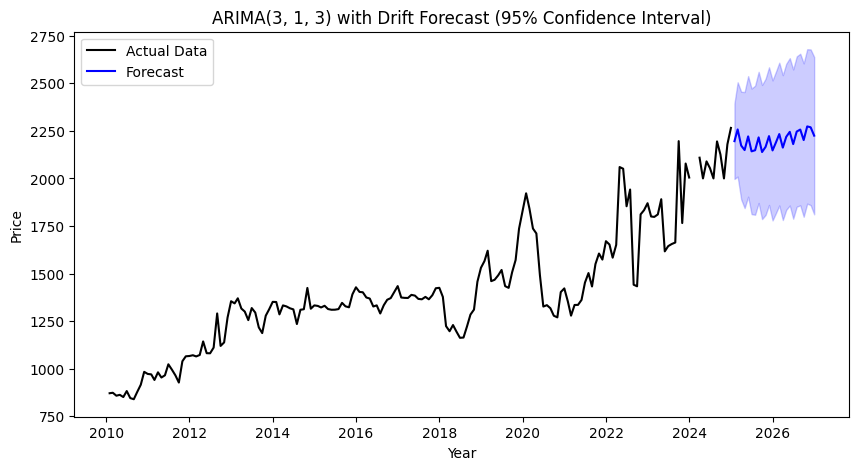

In [19]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("Dataset Nabarangpur Maize Avg Price.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Ensure 'Date' column exists
if 'Date' not in df.columns:
    raise KeyError("The dataset does not contain a 'Date' column. Check column names.")

# Convert 'Date' to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)
df = df.sort_index()

# Fit ARIMA(3,1,3) with drift
order = (3, 1, 3)
model = ARIMA(df['Avg Price'], order=order, trend='t')  # 't' includes drift
model_fit = model.fit()

# Forecast next 24 months
forecast_steps = 24
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Extract confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Avg Price'], label="Actual Data", color="black")

# Plot forecast
plt.plot(forecast_index, forecast_mean, label="Forecast", color="blue")

# Plot confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Price")
plt.title(f"ARIMA{order} with Drift Forecast (95% Confidence Interval)")
plt.legend()
plt.show()


In [20]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("Dataset Nabarangpur Maize Avg Price.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Ensure 'Date' column exists
if 'Date' not in df.columns:
    raise KeyError("The dataset does not contain a 'Date' column. Check column names.")

# Convert 'Date' to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)
df = df.sort_index()

# Fit ARIMA(3,1,3) with drift
order = (3, 1, 3)
model = ARIMA(df['Avg Price'], order=order, trend='t')  # 't' includes drift
model_fit = model.fit()

# Forecast from April 2024 to Dec 2026
forecast_start = "2024-04-01"  # Start forecasting from April 2024
forecast_steps = 33  # 9 months of known actuals + 24 future months
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='M')

# Get forecasted values
forecast = model_fit.get_prediction(start=forecast_index[0], end=forecast_index[-1])
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create a DataFrame for forecasted data
forecast_df = pd.DataFrame({
    "Month": forecast_index.strftime("%b-%y"),
    "Forecasted price": forecast_mean.values,
    "Low 95% confidence interval": conf_int.iloc[:, 0].values,
    "High 95% confidence interval": conf_int.iloc[:, 1].values
})

# Extract actual data for April-Dec 2024
df_actual = df.loc["2024-04-01":"2024-12-31"].reset_index()
df_actual["Month"] = df_actual["Date"].dt.strftime("%b-%y")
df_actual = df_actual[["Month", "Avg Price"]].rename(columns={"Avg Price": "Actual price"})

# Merge actual and forecasted data
full_df = pd.merge(forecast_df, df_actual, on="Month", how="left")

# Ensure NaN values are displayed for missing actuals (Jan 2025 onward)
full_df["Actual price"].fillna(np.nan, inplace=True)

# Display result
print(full_df.to_string(index=False))


 Month  Forecasted price  Low 95% confidence interval  High 95% confidence interval  Actual price
Apr-24       1997.696238                  1798.693598                   2196.698877   2000.000000
May-24       2058.636827                  1860.279283                   2256.994372   2089.583333
Jun-24       2065.177988                  1866.306386                   2264.049590   2054.259259
Jul-24       1976.364241                  1777.496622                   2175.231861   2000.000000
Aug-24       2070.357636                  1871.999185                   2268.716088   2194.666667
Sep-24       2135.622573                  1936.859952                   2334.385195   2126.000000
Oct-24       2064.646207                  1865.888098                   2263.404316   2000.000000
Nov-24       2083.949949                  1885.592238                   2282.307660   2179.190476
Dec-24       2108.373690                  1909.708631                   2307.038749   2265.468750
Jan-25       2195.86

In [26]:
# Assuming 'full_df' is already created as in the previous code

# Reorder columns
full_df = full_df[["Month", "Actual price", "Forecasted price", "Low 95% confidence interval", "High 95% confidence interval"]]

# Display the reordered DataFrame
print(full_df.to_string(index=False))


 Month  Actual price  Forecasted price  Low 95% confidence interval  High 95% confidence interval
Apr-24   2000.000000       1997.696238                  1798.693598                   2196.698877
May-24   2089.583333       2058.636827                  1860.279283                   2256.994372
Jun-24   2054.259259       2065.177988                  1866.306386                   2264.049590
Jul-24   2000.000000       1976.364241                  1777.496622                   2175.231861
Aug-24   2194.666667       2070.357636                  1871.999185                   2268.716088
Sep-24   2126.000000       2135.622573                  1936.859952                   2334.385195
Oct-24   2000.000000       2064.646207                  1865.888098                   2263.404316
Nov-24   2179.190476       2083.949949                  1885.592238                   2282.307660
Dec-24   2265.468750       2108.373690                  1909.708631                   2307.038749
Jan-25           NaN

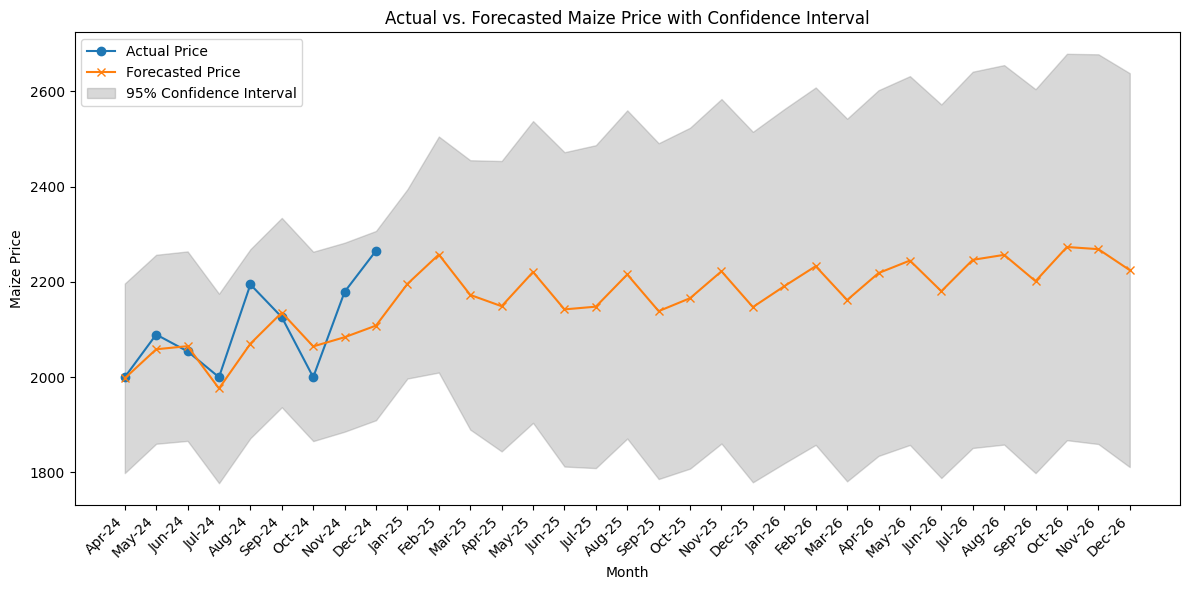

In [28]:
# Assuming 'full_df' is already created and contains the data as shown in the previous code output

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(full_df["Month"], full_df["Actual price"], label="Actual Price", marker='o')
plt.plot(full_df["Month"], full_df["Forecasted price"], label="Forecasted Price", marker='x')
plt.fill_between(full_df["Month"], full_df["Low 95% confidence interval"], full_df["High 95% confidence interval"], color='gray', alpha=0.3, label="95% Confidence Interval")

plt.xlabel("Month")
plt.ylabel("Maize Price")
plt.title("Actual vs. Forecasted Maize Price with Confidence Interval")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
def calculate_rmse(actual, predicted):
    """Calculates the Root Mean Squared Error (RMSE)."""
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return rmse

def calculate_mape(actual, predicted):
    """Calculates the Mean Absolute Percentage Error (MAPE)."""
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

# Example usage (assuming you have 'actual_prices' and 'forecast_prices'):
# Replace with your actual and forecasted price data
actual_prices = full_df["Actual price"].dropna().values  # Ensure to drop NaN values
forecast_prices = full_df["Forecasted price"][:len(actual_prices)].values # Align lengths

rmse = calculate_rmse(actual_prices, forecast_prices)
mape = calculate_mape(actual_prices, forecast_prices)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Evaluation
threshold_rmse = 100 # Set your RMSE threshold
threshold_mape = 10 # Set your MAPE threshold

if rmse < threshold_rmse and mape < threshold_mape:
    print("Forecast is accurate.")
else:
    print("Forecast is not accurate.")

RMSE: 78.26
MAPE: 2.66%
Forecast is accurate.


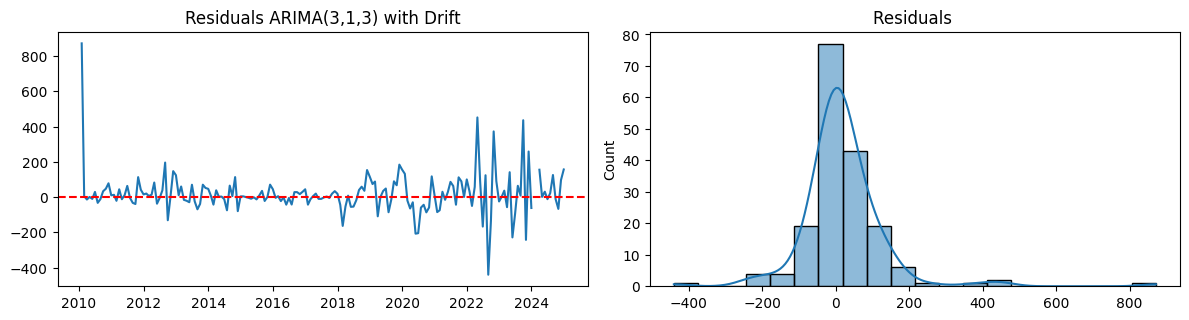

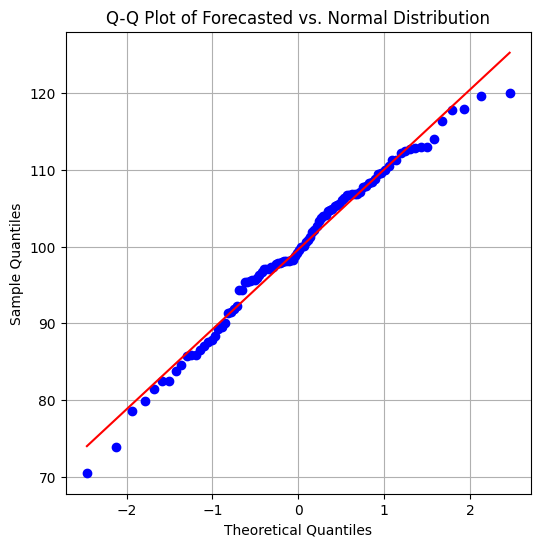

In [30]:
forecasted_prices = np.random.normal(loc=100, scale=10, size=100)

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

# Fit ARIMA(3,1,3) model
model = ARIMA(df["Avg Price"], order=(3, 1, 3))
fitted_model = model.fit()

# Extract residuals
residuals = fitted_model.resid

# Plot residuals
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residuals ARIMA(3,1,3) with Drift")

plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=20)
plt.title("Residuals ")
plt.tight_layout()


# Create Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(forecasted_prices, dist="norm", fit=True, plot=plt)

# Labels and title
plt.title("Q-Q Plot of Forecasted vs. Normal Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()


# Convert to Pandas Series
actual_series = pd.Series(actual_prices)
forecasted_series = pd.Series(forecasted_prices)


